The likelyhood of getting diabetes is altered by a number of factors including:

- Age
- Ethnicity
- Family History
- Weight
- Physical Inactivity
- Genetics
- Other Conditions: High blood pressure, high cholesterol, and heart disease increase the risk

To explore this data I will be using synthetic patients records from [Synthea](https://synthetichealth.github.io/synthea/) using a community version of a FHIR enabled Data Platform from Intersystems called IRIS [Intersystems Open Exchange - iris-fhir-template](https://openexchange.intersystems.com/package/iris-fhir-template).
These examples are based on US population demographics and will also use a mix of LOINC and SNOMED coding, so codes used are likely to differ from UK based systems which predominantly use SNOMED CT UK Edition.

162864005 	Body mass index 30+ - obesity
408512008   Body mass index 40+ - severely obese

In [79]:
import iris
import pandas as pd

host = "localhost"
# this is the superserver port
port = 32782
namespace = "FHIRSERVER"
user = "_SYSTEM"
password = "SYS"

conn = iris.connect(
    hostname=host,
    port=port,
    namespace=namespace,
    username=user,
    password=password
)

# create a cursor
cursor = conn.cursor()
cursor

sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
      from HSFHIR_X0001_S.Patient patient
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df['TYPE2DIABETES_AGE'] = df['TYPE2DIABETES_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df['HYPERTENSION_AGE'] = df['HYPERTENSION_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
print(df.describe())

               AGE     genderUK  TYPE2DIABETES  HYPERTENSION        OBESE  \
count  2387.000000  2387.000000    2387.000000   2387.000000  2387.000000   
mean     47.628404     1.501466       0.068705      0.250524     0.338500   
std      27.336157     0.500103       0.253006      0.433405     0.473299   
min       0.000000     1.000000       0.000000      0.000000     0.000000   
25%      25.000000     1.000000       0.000000      0.000000     0.000000   
50%      48.000000     2.000000       0.000000      0.000000     0.000000   
75%      67.000000     2.000000       0.000000      1.000000     1.000000   
max     111.000000     2.000000       1.000000      1.000000     1.000000   

        VERY_OBESE  TYPE2DIABETES_AGE  HYPERTENSION_AGE   OBESE_AGE  \
count  2387.000000        2387.000000       2387.000000  808.000000   
mean      0.003351           2.307918          4.819020   33.570545   
std       0.057807           8.784194          8.622711   10.531594   
min       0.000000    

Some of the values in the last section are wrong or nonsense, I will correct that later.

The mean AGE values are correct. This is visible in the diagram below.

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

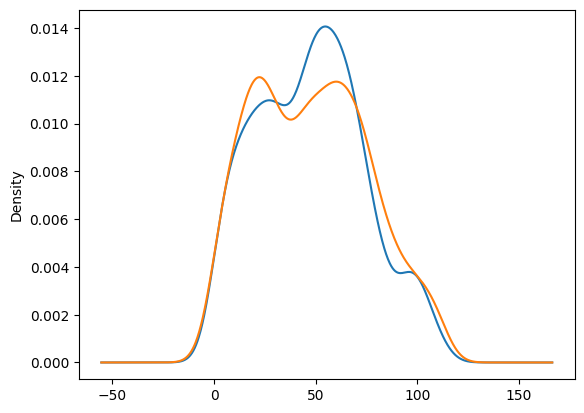

In [80]:
df.groupby('gender').AGE.plot(kind='kde')

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

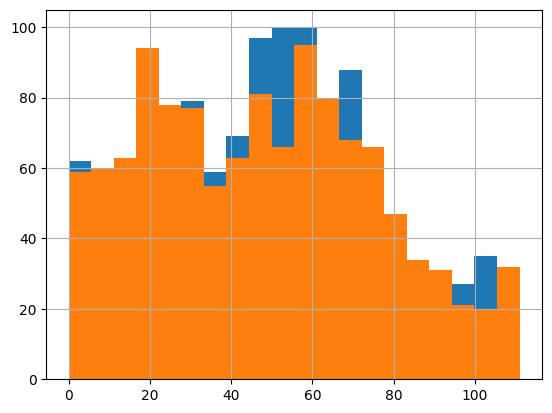

In [81]:
df.groupby('gender').AGE.hist(stacked=False, bins=20)

TYPE2DIABETES

              AGE    genderUK  TYPE2DIABETES  HYPERTENSION       OBESE  \
count  164.000000  164.000000          164.0    164.000000  164.000000   
mean    66.225610    1.445122            1.0      0.573171    0.243902   
std     21.562956    0.498501            0.0      0.496132    0.430750   
min     25.000000    1.000000            1.0      0.000000    0.000000   
25%     50.000000    1.000000            1.0      0.000000    0.000000   
50%     62.000000    1.000000            1.0      1.000000    0.000000   
75%     80.250000    2.000000            1.0      1.000000    0.000000   
max    111.000000    2.000000            1.0      1.000000    1.000000   

       VERY_OBESE  TYPE2DIABETES_AGE  HYPERTENSION_AGE  OBESE_AGE  \
count       164.0         164.000000        164.000000  40.000000   
mean          0.0          33.591463         14.414634  29.175000   
std           0.0           8.496707         14.225141  10.078888   
min           0.0          19.000000          0.000000  1

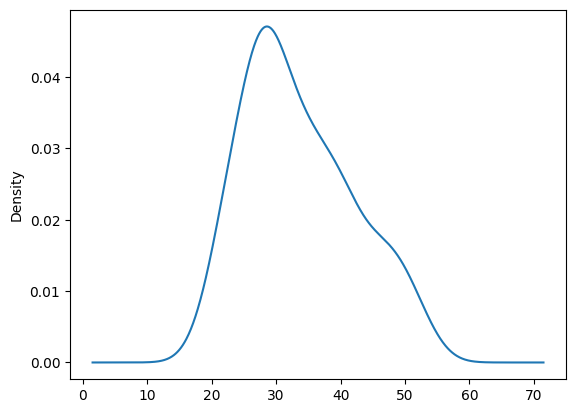

In [82]:
dfDiabetes = df[df.TYPE2DIABETES == 1].copy()
dfDiabetes.groupby('TYPE2DIABETES').TYPE2DIABETES_AGE.plot(kind='kde')

print(dfDiabetes.describe())

              AGE    genderUK  TYPE2DIABETES  HYPERTENSION       OBESE  \
count  598.000000  598.000000     598.000000         598.0  598.000000   
mean    56.846154    1.498328       0.157191           1.0    0.387960   
std     22.662621    0.500416       0.364285           0.0    0.487693   
min     19.000000    1.000000       0.000000           1.0    0.000000   
25%     40.250000    1.000000       0.000000           1.0    0.000000   
50%     56.000000    1.000000       0.000000           1.0    0.000000   
75%     71.000000    2.000000       0.000000           1.0    1.000000   
max    111.000000    2.000000       1.000000           1.0    1.000000   

       VERY_OBESE  TYPE2DIABETES_AGE  HYPERTENSION_AGE   OBESE_AGE  \
count  598.000000         598.000000        598.000000  232.000000   
mean     0.001672           5.153846         19.235786   32.728448   
std      0.040893          12.340768          4.401491   10.406020   
min      0.000000           0.000000         18.00000

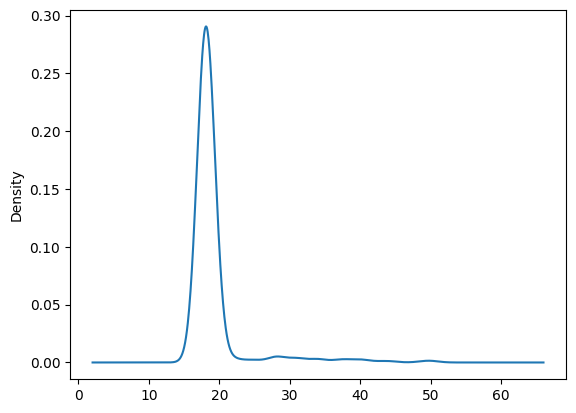

In [83]:
dfHypertension = df[df.HYPERTENSION == 1].copy()
dfHypertension.groupby('HYPERTENSION').HYPERTENSION_AGE.plot(kind='kde')

print(dfHypertension.describe())

              AGE    genderUK  TYPE2DIABETES  HYPERTENSION  OBESE  VERY_OBESE  \
count  808.000000  808.000000     808.000000    808.000000  808.0  808.000000   
mean    63.839109    1.523515       0.049505      0.287129    1.0    0.009901   
std     19.589691    0.499756       0.217054      0.452702    0.0    0.099071   
min     13.000000    1.000000       0.000000      0.000000    1.0    0.000000   
25%     49.750000    1.000000       0.000000      0.000000    1.0    0.000000   
50%     63.000000    2.000000       0.000000      0.000000    1.0    0.000000   
75%     76.000000    2.000000       0.000000      1.000000    1.0    0.000000   
max    111.000000    2.000000       1.000000      1.000000    1.0    1.000000   

       TYPE2DIABETES_AGE  HYPERTENSION_AGE   OBESE_AGE  VERY_OBESE_AGE  
count         808.000000        808.000000  808.000000        8.000000  
mean            1.974010          5.412129   33.570545       14.125000  
std             8.858271          8.831604   10.531

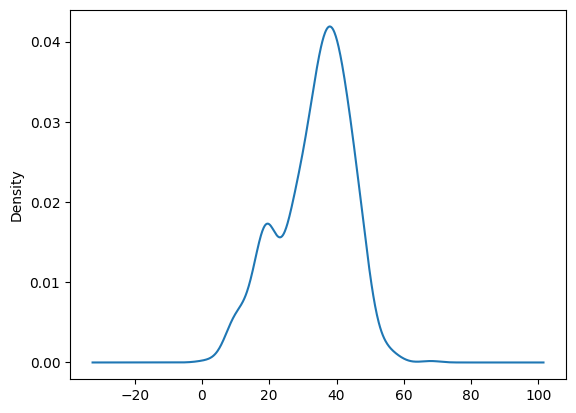

In [85]:
dfObese = df[df.OBESE == 1].copy()
dfObese.groupby('OBESE').OBESE_AGE.plot(kind='kde')

print(dfObese.describe())

In [ ]:
conn.close()
conn

In [ ]:
cursor.isClosed()
cursor